First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-01-26 01:33:32.678756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 01:33:32.681101: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 01:33:32.684677: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 01:33:32.694744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737873212.711243 2473727 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737873212.71

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

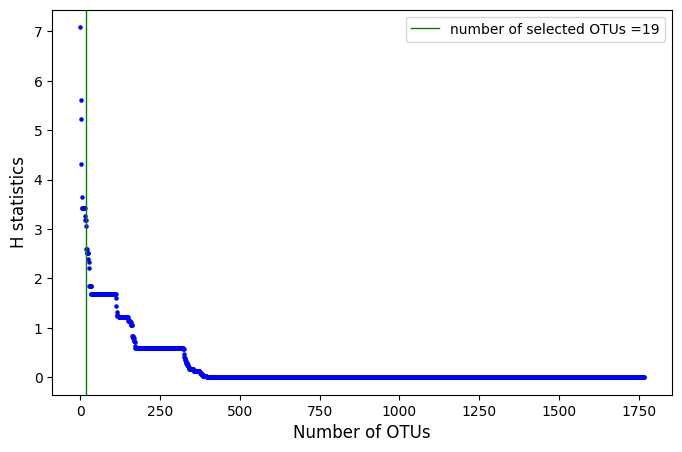

In [6]:
# select the OTUs

selectedresult=FS.SelectMicro_fun(df,duration_label)
    
selectedresult.keys()

In [7]:
selectedOTU_index_list = selectedresult['selected_indices']
selectedASV_list = selectedresult['selected_columnames']
X_FS_list = selectedresult['selected_data']
data = selectedresult['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [8]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [9]:
targetLabel=duration_label
print("The response variable and its counts are:")
print(targetLabel.value_counts())

X_FS = X_FS_list

X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)

X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)

X_FS_lasso,xlabel_FS_lasso0 = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
xlabel_FS_lasso = selectedOTU_index_list[xlabel_FS_lasso0]
X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
xlabel_FS_lasso_ft = selectedOTU_index_list[xlabel_FS_lasso_ft0]

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lasso":X_FS_lasso,
               "FS_Lassofinetune":X_FS_lasso_ft,
               #"Random":data
              }


The response variable and its counts are:
Duration
Perennial    37
Annual       22
Name: count, dtype: int64
Best alpha: 0.1
Best alpha: 0.05


In [10]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso selected dataset is ',np.shape(X_lasso))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))

The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 19)
The shape of the Lasso selected dataset is  (59, 47)
The shape of the Lasso_finetune selected dataset is  (59, 7)
The shape of the FS_Lasso selected dataset is  (59, 13)
The shape of the FS_Lasso_finetune selected dataset is  (59, 12)


In [11]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=cls,SMOTE=True)

Classes: ['Annual' 'Perennial']
[0.42857142857142855, 0.19999999999999998, 0.6875, 0.5625, 0.4107142857142857]
[0.2285714285714285, 0.14285714285714285, 0.59375, 0.75, 0.6428571428571428]
[0.2571428571428571, 0.22857142857142854, 0.75, 0.625, 0.3214285714285714]
[0.39999999999999997, 0.5285714285714286, 0.78125, 0.40625, 0.4642857142857143]
[1.0, 0.8, 1.0, 0.53125, 0.75]
[0.9142857142857144, 0.7142857142857143, 1.0, 0.8125, 0.6785714285714286]
[1.0, 0.7714285714285715, 1.0, 0.8125, 0.6785714285714286]
[0.8, 0.6857142857142857, 1.0, 0.875, 0.875]
[1.0, 0.7000000000000001, 0.96875, 0.75, 0.8571428571428571]
[1.0, 0.9142857142857143, 0.96875, 0.84375, 0.8214285714285714]
[1.0, 0.6, 1.0, 0.84375, 0.7857142857142857]
[0.7, 0.6285714285714286, 1.0, 0.75, 1.0]
[1.0, 0.7142857142857142, 0.875, 0.65625, 0.8214285714285714]
[1.0, 0.7714285714285714, 0.875, 0.65625, 0.7499999999999999]
[1.0, 0.6857142857142857, 0.875, 0.875, 0.7857142857142857]
[0.9, 0.6142857142857143, 0.875, 0.875, 0.8571428571

In [12]:
print(metric.metric_sum(dict_cm))

                           Accuracy  Precision   Recall   Specification  \
AllFeatures_RF             0.593220  0.333333   0.090909    0.891892      
AllFeatures_SVM            0.508475  0.230769   0.136364    0.729730      
AllFeatures_CatBoost       0.542373  0.222222   0.090909    0.810811      
AllFeatures_NB             0.508475  0.360000   0.409091    0.567568      
SelectMicro_RF             0.762712  0.785714   0.500000    0.918919      
SelectMicro_SVM            0.762712  0.785714   0.500000    0.918919      
SelectMicro_CatBoost       0.745763  0.769231   0.454545    0.918919      
SelectMicro_NB             0.864407  0.937500   0.681818    0.972973      
Lasso_RF                   0.762712  1.000000   0.363636    1.000000      
Lasso_SVM                  0.762712  0.833333   0.454545    0.945946      
Lasso_CatBoost             0.694915  0.700000   0.318182    0.918919      
Lasso_NB                   0.847458  0.933333   0.636364    0.972973      
Lasso_finetune_RF        

In [13]:
dict_cm2 = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=['xgboost'],SMOTE=True)

Classes: ['Annual' 'Perennial']
[0.7142857142857142, 0.3428571428571428, 0.75, 0.5, 0.5178571428571428]
[1.0, 0.8142857142857143, 0.90625, 0.28125, 0.4821428571428571]
[1.0, 0.4857142857142857, 0.65625, 0.46875, 0.4821428571428571]
[1.0, 0.6, 0.75, 0.4375, 0.6428571428571428]
[1.0, 0.6, 0.625, 0.4375, 0.6428571428571428]
[1.0, 0.6, 0.625, 0.4375, 0.6428571428571428]
                  xgboost_Accuracy  xgboost_AUC  xgboost_Accuracy_std  \
AllFeatures           0.607576       0.565000          0.153502         
SelectMicro           0.727273       0.696786          0.114792         
Lasso                 0.659091       0.618571          0.179019         
Lasso_finetune        0.712121       0.686071          0.112060         
FS_Lasso              0.727273       0.661071          0.146665         
FS_Lassofinetune      0.727273       0.661071          0.146665         

                  xgboost_AUC_std  xgboost_mcc  xgboost_F  
AllFeatures          0.149871       0.151522    0.698730   

## compare the first 20 index

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=selectedOTU_index_list[:entries]
selectedASVs20_list = selectedASV_list[:entries]

Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
     OTU    presence_pos  presence_neg
0   ASV237    0.181818      0.000000  
1    ASV15    0.272727      0.054054  
2   ASV310    0.136364      0.000000  
3    ASV61    0.181818      0.027027  
4    ASV53    0.227273      0.054054  
5    ASV65    0.090909      0.000000  
6   ASV122    0.090909      0.000000  
7   ASV161    0.090909      0.000000  
8   ASV227    0.090909      0.000000  
9   ASV241    0.090909      0.000000  
10  ASV250    0.090909      0.000000  
11  ASV270    0.090909      0.000000  
12  ASV271    0.090909      0.000000  
13  ASV276    0.090909      0.000000  
14  ASV304    0.090909      0.000000  
15    ASV3    0.318182      0.135135  
16   ASV66    0.000000      0.135135  
17   ASV85    0.000000      0.135135  
18   ASV27    0.090909      0.297297  


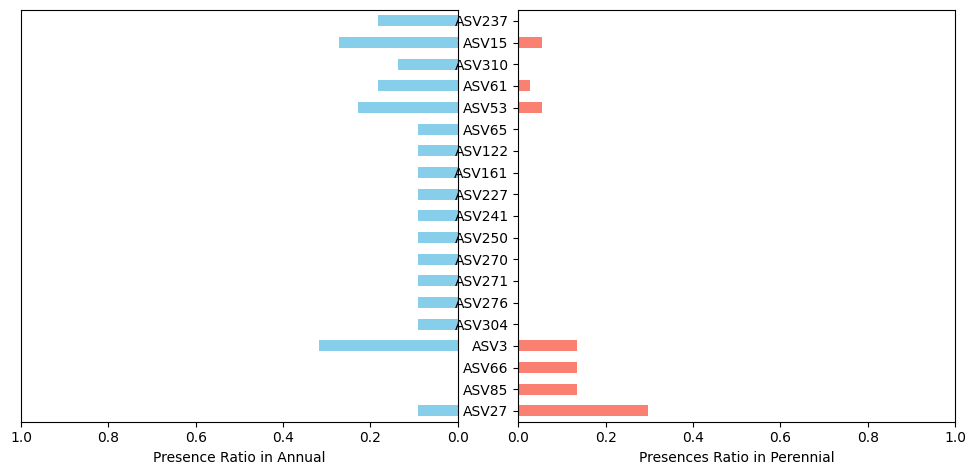

Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
    OTU    presence_pos  presence_neg
0   ASV15    0.272727      0.054054  
1   ASV61    0.181818      0.027027  
2  ASV250    0.090909      0.000000  
3  ASV270    0.090909      0.000000  
4  ASV271    0.090909      0.000000  
5  ASV276    0.090909      0.000000  
6  ASV310    0.136364      0.000000  


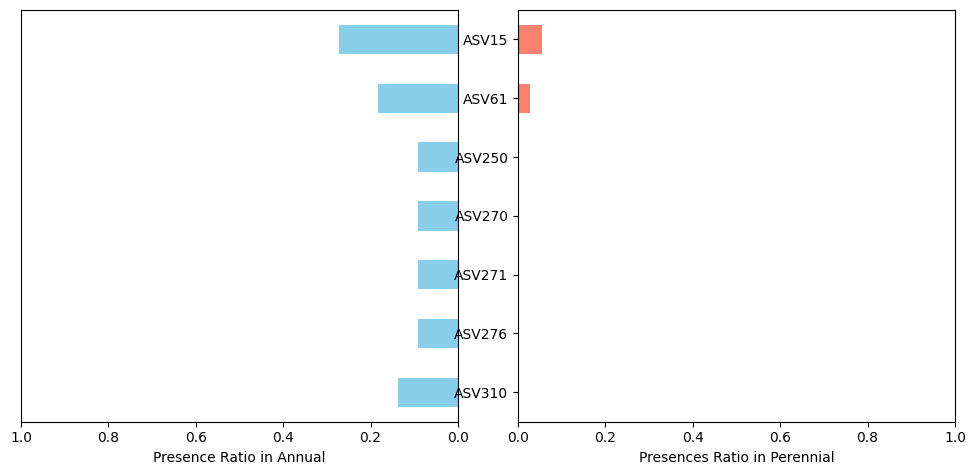

Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
     OTU    presence_pos  presence_neg
0    ASV15    0.272727      0.054054  
1   ASV310    0.136364      0.000000  
2    ASV61    0.181818      0.027027  
3    ASV65    0.090909      0.000000  
4   ASV161    0.090909      0.000000  
5   ASV250    0.090909      0.000000  
6   ASV270    0.090909      0.000000  
7   ASV271    0.090909      0.000000  
8   ASV276    0.090909      0.000000  
9   ASV304    0.090909      0.000000  
10   ASV66    0.000000      0.135135  
11   ASV85    0.000000      0.135135  


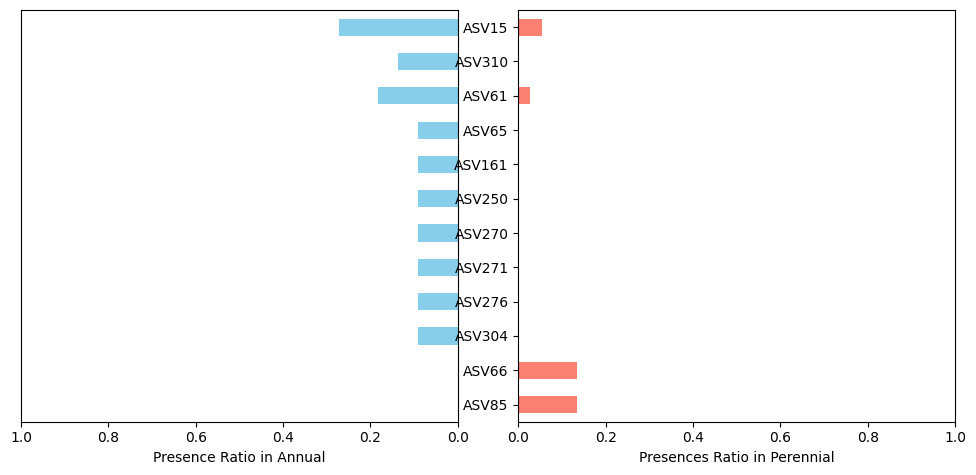

In [16]:

FS.plotPresenseRatio(data[:,selectedOTU_index_15_list],targetLabel,selectedASVs20_list,
                     posLabel="Annual",posText="Annual",negText="Perennial")

FS.plotPresenseRatio(X_lasso_ft,targetLabel,ASVs[xlabel_lasso_ft],
                     posLabel="Annual",posText="Annual",negText="Perennial")

FS.plotPresenseRatio(X_FS_lasso_ft,targetLabel,ASVs[xlabel_FS_lasso_ft],
                    posLabel="Annual",posText="Annual",negText="Perennial")